In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score
from tensorflow.keras import Sequential, Input, layers


import sys
sys.path.append('../src')

from src.utils.data import get_csv_from_bq,select_tomo_ids

#from utils.model_plot import plot_history2
from src.utils.model_plot import plot_history_regression
from src.ml_logic.preprocess import batches_images_ram,selection_images_labels,read_img_jpg

2025-06-05 10:50:20.485051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('../data/csv_raw/train_labels.csv')
df.head(10)

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors
0,0,16,tomo_049310,-1.0,-1.0,-1.0,500,924,956,19.7,0
1,1,30,tomo_098751,-1.0,-1.0,-1.0,500,924,956,16.1,0
2,2,54,tomo_136c8d,-1.0,-1.0,-1.0,500,924,956,19.7,0
3,3,59,tomo_146de2,-1.0,-1.0,-1.0,500,924,956,16.1,0
4,4,84,tomo_1dc5f9,-1.0,-1.0,-1.0,500,924,956,19.7,0
5,5,121,tomo_28f9c1,-1.0,-1.0,-1.0,500,924,956,16.1,0
6,6,173,tomo_39b15b,-1.0,-1.0,-1.0,500,924,956,16.1,0
7,7,181,tomo_3b8291,-1.0,-1.0,-1.0,500,924,956,19.7,0
8,8,193,tomo_40b215,-1.0,-1.0,-1.0,500,924,956,16.1,0
9,9,219,tomo_4baff0,-1.0,-1.0,-1.0,500,924,956,16.1,0


In [14]:
df[df['tomo_id']=='tomo_6f0ee4']#['Motor_axis_2','Motor_axis_1']

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors
369,369,330,tomo_6f0ee4,165.0,336.0,202.0,300,959,928,15.6,1


In [11]:
filtered_image_paths,labels = selection_images_labels(df,  'mean_image_padded', num_slices=[300], num_motors=[1])
filtered_image_paths[0],labels[0]


Found 648 images in ../data/pictures_process/mean_image_padded
Matched 305 image-label pairs


('../data/pictures_process/mean_image_padded/image_moyenne_tomo_05df8a.jpg',
 array([762., 257.], dtype=float32))

In [12]:

#dataset_new = batches_images_ram(read_img_jpg,filtered_image_paths,labels)
train_ds, val_ds, test_ds,test_paths,test_labels = batches_images_ram(
    read_img_jpg,
    filtered_image_paths,
    labels,
    shuffle=True,
    batch_size=32,
    split=True,
    val_fraction=0.2,
    test_fraction=0.2,
    seed=42)

2025-06-05 11:20:43.470167: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf.Tensor([202. 336.], shape=(2,), dtype=float32)
../data/pictures_process/mean_image_padded/image_moyenne_tomo_6f0ee4.jpg
tf.Tensor([373. 512.], shape=(2,), dtype=float32)
../data/pictures_process/mean_image_padded/image_moyenne_tomo_a537dd.jpg
tf.Tensor([228. 706.], shape=(2,), dtype=float32)
../data/pictures_process/mean_image_padded/image_moyenne_tomo_30d4e5.jpg
tf.Tensor([382. 218.], shape=(2,), dtype=float32)
../data/pictures_process/mean_image_padded/image_moyenne_tomo_d21396.jpg
tf.Tensor([600. 295.], shape=(2,), dtype=float32)
../data/pictures_process/mean_image_padded/image_moyenne_tomo_8e8368.jpg
tf.Tensor([416. 424.], shape=(2,), dtype=float32)
../data/pictures_process/mean_image_padded/image_moyenne_tomo_71ece1.jpg
tf.Tensor([522. 302.], shape=(2,), dtype=float32)
../data/pictures_process/mean_image_padded/image_moyenne_tomo_9f222a.jpg
tf.Tensor([751. 323.], shape=(2,), dtype=float32)
../data/pictures_process/mean_image_padded/image_moyenne_tomo_6733fa.jpg
tf.Tensor([560. 

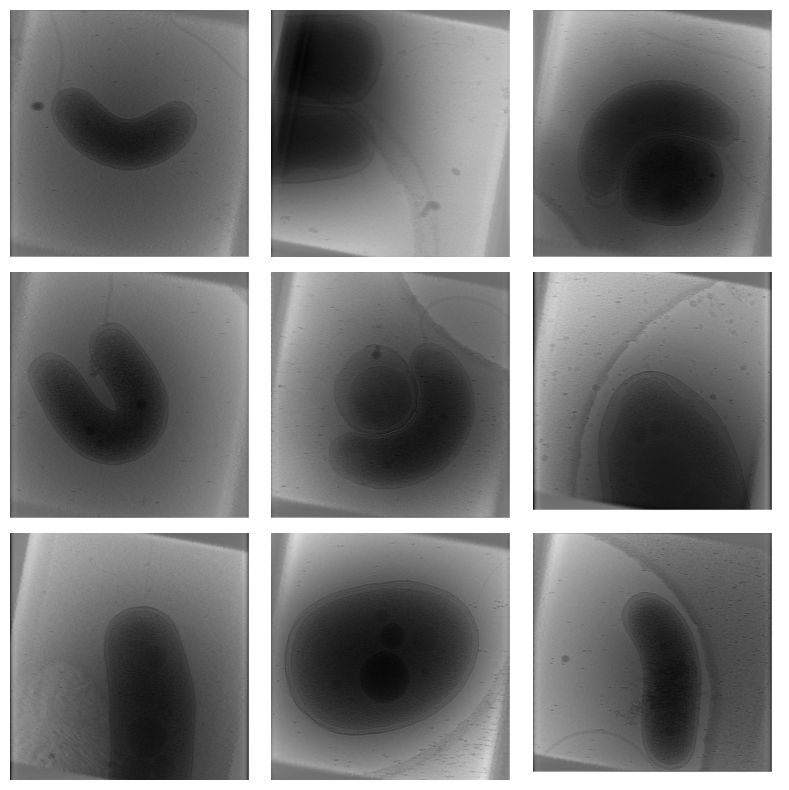

In [15]:
import matplotlib.pyplot as plt
from src.utils.render_motor_position import draw_on_image


# Take one batch (e.g., 32 images)
for batch in test_ds.take(1):
    images, _ = batch  # just images
    _ ,labels = batch
    break

# Plot first 9 images in a 3x3 grid
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = tf.squeeze(images[i])
    x_true, y_true = labels[i]
    print(labels[i])
    plt.imshow(img.numpy(),cmap='gray')
    draw_on_image(test_paths[i], '../data/pictures_process/motor_position_true_mean/', x_true, y_true)
    print(test_paths[i])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
def initiate_model():

    model = Sequential()
     ### First Convolution & MaxPooling
    model.add(Input(shape=(960, 960, 1)))
    model.add(layers.Conv2D(32, (3,3), activation = 'relu',padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Conv2D(64, (4,4), activation = 'relu',padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3, 3)))

    ## Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(10,activation='relu'))

    model.add(layers.Dropout(0.3))  # Optional
    model.add(layers.Dense(2,activation='linear'))

    return model

In [23]:
model = initiate_model()
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 960, 960, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 320, 320, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 320, 320, 64)      32832     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 106, 106, 64)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 719104)            0         
                                                                 
 dense_2 (Dense)             (None, 10)               

In [31]:
import tensorflow as tf
def euclidean_loss(y_true, y_pred):
    return tf.reduce_mean(tf.norm(y_pred - y_true, axis=1))
def compile_model(model):
    ### Model compilation
    model.compile(loss=euclidean_loss,optimizer='adam',metrics=[euclidean_loss], run_eagerly=True)
    return model

#def compile_model(model):
    ### Model compilation
#    model.compile(loss='mse',optimizer='adam',metrics=['mse'], run_eagerly=True)
#    return model


In [32]:
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

model = initiate_model()
model = compile_model(model)

es = EarlyStopping(patience=5)
history = model.fit(
      train_ds,
      validation_data=val_ds,
      #shuffle= True,
      batch_size=32,
      epochs=50,
      callbacks=[es],
      verbose=1
      )

2025/06/05 12:37:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3b139681278e4e7694cc058f33dcc701', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/50


KeyboardInterrupt: 

In [33]:
from src.ml_logic.interface import train
model = initiate_model()
model = compile_model(model)

train(model,
        train_ds,
        val_ds,
        model_type='pos2D',
        preprocess_type='mean_padded',
        model_name='pos2d mean padded patience 5 ',
        batch_size = 32,
        patience = 5
    )


🏋️ Starting model training ...

Training model...
Epoch 1/100
6/6 [==============================] - 97s 16s/step - loss: 646.5532 - euclidean_loss: 638.6938 - val_loss: 506.5925 - val_euclidean_loss: 505.7939
Epoch 2/100
6/6 [==============================] - 83s 14s/step - loss: 436.5571 - euclidean_loss: 428.4331 - val_loss: 274.2190 - val_euclidean_loss: 273.7273
Epoch 3/100
6/6 [==============================] - 88s 15s/step - loss: 277.7654 - euclidean_loss: 278.1384 - val_loss: 323.8692 - val_euclidean_loss: 324.5127
Epoch 4/100
6/6 [==============================] - 87s 15s/step - loss: 300.4615 - euclidean_loss: 298.2576 - val_loss: 246.2587 - val_euclidean_loss: 246.2183
Epoch 5/100
6/6 [==============================] - 90s 15s/step - loss: 259.0475 - euclidean_loss: 258.1902 - val_loss: 250.6034 - val_euclidean_loss: 250.2981
Epoch 6/100
6/6 [==============================] - 89s 15s/step - loss: 264.4784 - euclidean_loss: 262.8127 - val_loss: 242.4578 - val_euclidean_loss

INFO:tensorflow:Assets written to: /var/folders/nj/wg4pl11n6hb1zcpwyf6khsxr0000gn/T/tmpf7ws90nk/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/nj/wg4pl11n6hb1zcpwyf6khsxr0000gn/T/tmpf7ws90nk/model/data/model/assets
2025/06/05 13:19:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/nj/wg4pl11n6hb1zcpwyf6khsxr0000gn/T/tmpf7ws90nk/model, flavor: tensorflow), fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback.


KeyError: 'val_mse'

In [ ]:
from src.ml_logic.registry import load_model

model_trained = load_model(model_name='pos2d mean padded patience 5 ', stage='STAGING')

loss, mse = model_trained.evaluate(test_ds)
print("Test loss:", loss)
print("Test MSE:", mse)



Load model [pos2d mean ] from MLflow...
✅ model loaded from mlflow
2/2 [==============================] - 5s 2s/step - loss: 38414.3359 - mse: 38414.3359
Test loss: 38414.3359375
Test MSE: 38414.3359375


In [ ]:
from src.utils.render_motor_position import draw_on_image

# Predict
predictions = model_trained.predict(test_ds)

# Draw
for i in range(len(test_paths)):
    x_true, y_true = test_labels[i]
    x_pred, y_pred = predictions[i]
    image_path = test_paths[i]
    draw_on_image(image_path, '../data/pictures_process/motor_position_predict_mean_padded/', x_true, y_true, x_pred, y_pred)


2/2 [==============================] - 5s 2s/step
